In [1]:
import seaborn as sns
import visualization as vs
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
from scipy import stats
from functools import reduce
from seaborn.utils import ci

In [3]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

# H-MFN

In [4]:
# wp_final = pd.read_csv("final/wp-150/wp-H-2-10-CP-MFN.csv")
# bk_final = pd.read_csv("final/bk-150/bk-H-2-10-CP-MFN.csv")
# gw_final = pd.read_csv("final/gws-150/gws-H-2-10-CP-MFN.csv")

wp_final = pd.read_csv("final/wp-150/wp-H-2-10-MeetupNp-MFN.csv")
bk_final = pd.read_csv("final/bk-150/bk-H-2-10-MeetupNp-MFN.csv")
gw_final = pd.read_csv("final/gws-150/gws-H-2-10-MeetupNp-MFN.csv")

wp_final['dataset'] = "Weeplace"
bk_final['dataset'] = "BrightKite"
gw_final['dataset'] =  "Gowalla"

In [5]:
def transform_df(df_H_MFN):
    df_H_MFN = df_H_MFN[['Included Rank','userid_y', 'CCE_alters', 'CCE_ego_alters', 'Pi_alters', 'Pi_ego_alters', 
                                     'LZ_entropy', 'Pi', 'n_meetupers_x', 'n_meetupers_y', 'userid_x', 'dataset']]
    df_H_MFN = df_H_MFN.rename({'Included Rank': 'Included', 
                                'userid_x': 'userid',
                                'Pi': 'Pi_ego'}, axis=1)
    df_H_MFN['Pi_alters_ratio'] = df_H_MFN['Pi_alters'] / df_H_MFN['Pi_ego'] 
    df_H_MFN['Pi_ego_alters_ratio'] = df_H_MFN['Pi_ego_alters'] / df_H_MFN['Pi_ego'] 
    return df_H_MFN

In [6]:
df_final = transform_df(pd.concat([wp_final, bk_final, gw_final]))

In [7]:
df_used = df_final[(df_final['Included'] <=10) & (df_final['n_meetupers_x']>=10)]

In [46]:
df_used.groupby('dataset')['userid'].count()

dataset
BrightKite    1690
Gowalla       2500
Weeplace      7510
Name: userid, dtype: int64

In [8]:
lower = df_used.groupby(['Included', 
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper = df_used.groupby(['Included', 
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid = df_used.groupby(['Included', 'dataset'])['Pi_alters_ratio'].mean().reset_index()

In [9]:
final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'dataset']), [mid, lower, upper])
final.columns = ['included', 'dataset', 'mean', 'lower', 'upper']

In [10]:
# final.to_csv('final/150_all_2_10_CP_H_MFN.csv', index=False)
final.to_csv('final/150_all_2_10_MeetupNp_H_MFN.csv', index=False)

In [29]:
# spearman test

In [11]:
ds_list = df_used['dataset'].unique().tolist()
user_list = df_used['userid'].unique().tolist()

In [49]:
for ds in ds_list:
    count_sm = 0
    count_kd = 0
    df_temp = df_used[df_used['dataset'] == ds]
    ur_ds = df_temp['userid'].unique().tolist()
    for user in ur_ds:
        rank = df_temp[df_temp['userid'] == user]['Included'].tolist()
        Pi_alters_ratio = df_temp[df_temp['userid'] == user]['Pi_alters_ratio'].tolist()
        
        coef_sm, p_sm = spearmanr(rank, Pi_alters_ratio)
        coef_kd, p_kd = kendalltau(rank, Pi_alters_ratio)     
        
        if (coef_sm > 0) & (p_sm < 0.05):
            count_sm +=1
        
        if (coef_kd > 0) & (p_kd < 0.05):
            count_kd +=1

    print(ds, count_sm, count_sm/len(ur_ds), count_kd, count_kd/len(ur_ds),len(ur_ds))

Weeplace 694 0.9241011984021305 700 0.9320905459387483 751
BrightKite 141 0.834319526627219 144 0.8520710059171598 169
Gowalla 222 0.888 229 0.916 250


# All these MFNs and TFN (pointplot)

In [15]:
# wp_all = pd.read_csv("final/wp-150/wp_shared_all_2_10_CP.csv")
# bk_all = pd.read_csv("final/bk-150/bk_shared_all_2_10_CP.csv")
# gw_all = pd.read_csv("final/gws-150/gws_shared_all_2_10_CP.csv")

wp_all = pd.read_csv("final/wp-150/wp_shared_all_2_10_MeetupNp.csv")
bk_all = pd.read_csv("final/bk-150/bk_shared_all_2_10_MeetupNp.csv")
gw_all = pd.read_csv("final/gws-150/gws_shared_all_2_10_MeetupNp.csv")

wp_all['dataset'] = "Weeplace"
bk_all['dataset'] = "BrightKite"
gw_all['dataset'] =  "Gowalla"

In [17]:
df_all = pd.concat([wp_all, bk_all, gw_all])

In [18]:
df_all_used = df_all[(df_all['Included'] <=10) & (df_all['n_meetupers_x']>=10)]

In [19]:
df_all_used.groupby(['dataset', 'category', 'userid']).apply(lambda row: spearmanr(row.Included, row.Pi_alters_ratio))

dataset     category   userid          
BrightKite  CB-1D-MFN  0.0                 (0.9999999999999999, 6.646897422032013e-64)
                       2.0                 (0.9878787878787878, 9.307459988955517e-08)
                       3.0                 (0.9636363636363635, 7.320974809529922e-06)
                       7.0                 (0.9515151515151514, 2.279854920641689e-05)
                       11.0                (0.9393939393939393, 5.484052998513666e-05)
                                                              ...                     
Weeplace    TFN        yuna-park           (0.9999999999999999, 6.646897422032013e-64)
                       yuri-van-geest      (0.9636363636363635, 7.320974809529922e-06)
                       zach-linder         (0.9999999999999999, 6.646897422032013e-64)
                       zachariah-schaap    (0.9999999999999999, 6.646897422032013e-64)
                       zachary-blank       (0.9878787878787878, 9.307459988955517e-08)
Len

In [20]:
category = list(set(df_all_used['category'].tolist()))

In [ ]:
result = []
for ds in ds_list:
    for cat in category:
        count_sm = 0
        count_kd = 0
        count_mw = 0
        
        df_temp = df_all_used[(df_all_used['dataset'] == ds) & (df_all_used['category'] == cat)]
        ur_ds = df_temp['userid'].unique().tolist()
        for user in ur_ds:
            rank = df_temp[df_temp['userid'] == user]['Included'].tolist()
            Pi_alters_ratio = df_temp[df_temp['userid'] == user]['Pi_alters_ratio'].tolist()

            coef_sm, p_sm = spearmanr(rank, Pi_alters_ratio)
            coef_kd, p_kd = kendalltau(rank, Pi_alters_ratio)  
            mannwhitneyu
            

            if (coef_sm > 0) & (p_sm < 0.05):
                count_sm +=1

            if (coef_kd > 0) & (p_kd < 0.05):
                count_kd +=1

#         print(ds, cat, count_sm, count_sm/len(ur_ds), count_kd, count_kd/len(ur_ds),len(ur_ds))
        result.append([ds, cat, count_sm, count_sm/len(ur_ds), count_kd, count_kd/len(ur_ds),len(ur_ds)])

In [53]:
pd.DataFrame(result, columns = ['Dataset', 
                                'MF',
                               'SpN',
                               'SpP',
                               'Kn',
                                'Kp',
                                'total']).sort_values(['Dataset', 'MF'])

,Dataset,MF,SpN,SpP,Kn,Kp,total
7,BrightKite,CB-1D-MFN,57,0.863636,59,0.893939,66
6,BrightKite,CB-1H-MFN,57,0.863636,59,0.893939,66
4,BrightKite,SW-24H-MFN,59,0.893939,60,0.909091,66
5,BrightKite,TFN,55,0.833333,57,0.863636,66
11,Gowalla,CB-1D-MFN,130,0.915493,133,0.936620,142
10,Gowalla,CB-1H-MFN,129,0.908451,132,0.929577,142
8,Gowalla,SW-24H-MFN,129,0.908451,130,0.915493,142
9,Gowalla,TFN,125,0.880282,129,0.908451,142
3,Weeplace,CB-1D-MFN,278,0.975439,281,0.985965,285
2,Weeplace,CB-1H-MFN,269,0.943860,272,0.954386,285


In [23]:
category

['SW-24H-MFN', 'TFN', 'CB-1H-MFN', 'CB-1D-MFN']

In [ ]:
final = []
for ds in ds_list:
    df_temp = df_all_used[df_all_used['dataset'] == ds]

    df_SW = df_temp[df_temp['category'] == category[0]]['Pi_alters_ratio']
    df_1D = df_temp[df_temp['category'] == category[1]]['Pi_alters_ratio']
    df_1H = df_temp[df_temp['category'] == category[2]]['Pi_alters_ratio']
    df_T = df_temp[df_temp['category'] == category[3]]['Pi_alters_ratio']

                               
    stats_S_D, p_S_D = wilcoxon(df_SW, df_1D)
    stats_S_H, p_S_H = wilcoxon(df_SW, df_1H)
    stats_S_T, p_S_T = wilcoxon(df_SW, df_T)
    
    stats_D_H, p_D_H = wilcoxon(df_1D, df_1H)
    stats_D_T, p_D_T = wilcoxon(df_1D, df_T)
    
    stats_H_T, p_H_T = wilcoxon(df_1H, df_T)
   

    df_stats = pd.DataFrame([[stats_S_D, p_S_D ], 
                             [stats_S_H, p_S_H],
                             [stats_S_T, p_S_T], 
                             [stats_D_H, p_D_H],
                            [stats_D_T, p_D_T], 
                             [stats_H_T, p_H_T]
                            ])
    df_stats['dataset'] = ds
    final.append(df_stats)
final = pd.concat(final)

In [55]:
final

,0,1,dataset
0,950901.0,7.419011e-45,Weeplace
1,1000624.0,6.017358e-26,Weeplace
2,517469.0,2.503702e-49,Weeplace
3,590132.0,5.382397e-11,Weeplace
4,1199502.0,1.018429e-05,Weeplace
5,1203929.0,1.900097e-01,Weeplace
0,71089.0,7.161085e-07,BrightKite
1,35053.0,3.073305e-25,BrightKite
2,62553.0,4.500120e-02,BrightKite
3,46733.0,2.765028e-03,BrightKite


In [57]:
# CI computation

In [25]:
lower = df_all_used.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper = df_all_used.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid = df_all_used.groupby(['Included', 'category',
                           'dataset'])['Pi_alters_ratio'].mean().reset_index()

In [26]:
all_final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [mid, lower, upper])
all_final.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']

In [27]:
# all_final.to_csv('final/150_all_category_CP.csv', index=False)
all_final.to_csv('final/150_all_category_MeetupNp.csv', index=False)

# All these MFNs and TFN (Global Jaccard Similarity)

In [28]:
import pickle
import matplotlib.pyplot as plt

In [29]:
# pickle_in = open("final/wp-150/wp_VIP_similarity_CP.pickle", "rb")
# wp_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/bk-150/bk_VIP_similarity_CP.pickle", "rb")
# bk_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/gws-150/gws_VIP_similarity_CP.pickle", "rb")
# gws_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

pickle_in = open("final/wp-150/wp_VIP_similarity_MeetupNp.pickle", "rb")
wp_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("final/bk-150/bk_VIP_similarity_MeetupNp.pickle", "rb")
bk_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("final/gws-150/gws_VIP_similarity_MeetupNp.pickle", "rb")
gws_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

In [30]:
df = [bk_vip_similarity, gws_vip_similarity, wp_vip_similarity]

In [31]:
datasets = ['BrightKite', 'Gowalla', 'Weeplace']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':


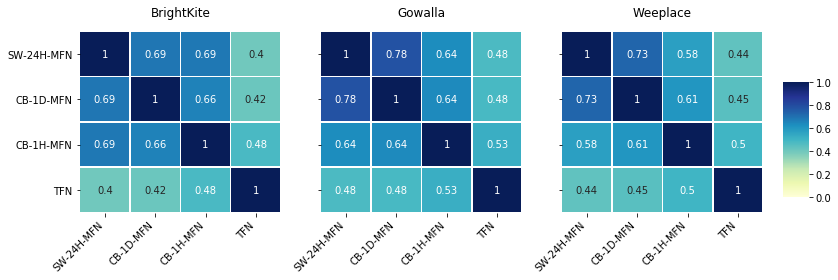

In [32]:
fig, axn = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(df[i] , cmap="YlGnBu", ax=ax, linewidths=.5, annot=True,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)
    ax.xaxis.set_label_position('bottom')
    ax.set_title(datasets[i], pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('fig/VIP_similarity_MeetupNp.pdf')

# VIP LR

In [33]:
# wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_CP.csv')
# wp_vip_LR['dataset'] = 'Weeplace'

# bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_CP.csv')
# bk_vip_LR['dataset'] = 'BrightKite'

# gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_CP.csv')
# gw_vip_LR['dataset'] = 'Gowalla'

wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_MeetupNp.csv')
wp_vip_LR['dataset'] = 'Weeplace'

bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_MeetupNp.csv')
bk_vip_LR['dataset'] = 'BrightKite'

gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_MeetupNp.csv')
gw_vip_LR['dataset'] = 'Gowalla'

In [34]:
vip_LR = pd.concat([wp_vip_LR, bk_vip_LR, gw_vip_LR])

In [36]:
vip_lower = vip_LR.groupby(['Included', 'category',
                         'dataset'])['USLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_LR.groupby(['Included', 'category',
                         'dataset'])['USLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_LR.groupby(['Included', 'category', 'dataset'])['USLR'].mean().reset_index()
vip_USLR = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_USLR.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']
vip_USLR['LR'] = 'USLR'

In [37]:
vip_lower = vip_LR.groupby(['Included', 'category',
                         'dataset'])['SLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_LR.groupby(['Included', 'category',
                         'dataset'])['SLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_LR.groupby(['Included', 'category', 'dataset'])['SLR'].mean().reset_index()

vip_SLR = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_SLR.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']
vip_SLR['LR'] = 'SLR'

In [38]:
vip_LR_final = pd.concat([vip_USLR, vip_SLR])

In [39]:
# vip_LR_final.to_csv('final/150_all_LR_CP.csv', index=False)
vip_LR_final.to_csv('final/150_all_LR_MeetupNp.csv', index=False)

# H-MFN vs TFN Cross validation

In [99]:
wp_vip_cv =  pd.read_csv('final/wp-150-cv/wp_join_vip10_CV.csv')
wp_vip_cv['dataset'] = 'Weeplace'

bk_vip_cv = pd.read_csv('final/bk-150-cv/bk_join_vip10_CV.csv')
bk_vip_cv['dataset'] = 'BrightKite'

gw_vip_cv = pd.read_csv('final/gws-150-cv/gws_join_vip10_CV.csv')
gw_vip_cv['dataset'] = 'Gowalla'

In [100]:
vip_CV = pd.concat([wp_vip_cv, bk_vip_cv, gw_vip_cv])

In [101]:
vip_CV 

,Included,alters_names,CCE_alters,CCE_ego_alters,Pi_alters,Pi_ego_alters,Pi_alters_ratio,Pi_ego_alters_ratio,userid,category,dataset
0,1,'don-chwojko',8.171960,4.554808,0.036762,0.567411,0.065429,1.009866,suzanne-marlatt,CB-1H-MFN,Weeplace
1,1,'katey-mcgarr',6.124336,4.478870,0.373008,0.576175,0.663872,1.025463,suzanne-marlatt,CB-1H-MFN,Weeplace
2,1,'richlocation',8.007438,4.556638,0.076338,0.567199,0.135865,1.009489,suzanne-marlatt,CB-1H-MFN,Weeplace
3,1,'pamela-vaughter',8.004760,4.544118,0.076913,0.568648,0.136889,1.012067,suzanne-marlatt,CB-1H-MFN,Weeplace
4,1,'kerry-sugrue',7.950789,4.554513,0.088221,0.567446,0.157014,1.009927,suzanne-marlatt,CB-1H-MFN,Weeplace
...,...,...,...,...,...,...,...,...,...,...,...
296665,9,"'10066','10950','10117','54963','25028','25024...",6.839218,6.708959,0.426669,0.439928,1.052095,1.084788,10971,TFN,Gowalla
296666,9,"'10066','10950','10869','54963','25028','25024...",6.766509,6.675511,0.434083,0.443315,1.070376,1.093142,10971,TFN,Gowalla
296667,9,"'10066','10117','10869','54963','25028','25024...",6.825001,6.687089,0.428121,0.442143,1.055676,1.090252,10971,TFN,Gowalla
296668,9,"'10950','10117','10869','54963','25028','25024...",6.886504,6.706455,0.421830,0.440181,1.040163,1.085415,10971,TFN,Gowalla


In [103]:
vip_lower = vip_CV.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_CV.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_CV.groupby(['Included', 'category', 'dataset'])['Pi_alters_ratio'].mean().reset_index()
vip_CV_final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_CV_final.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']

In [105]:
vip_CV_final.to_csv('final/150_all_CV.csv', index=False)